In [1]:
import collections

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotnine
import scipy.stats
import seaborn as sns
import sklearn.metrics

import analysis

%matplotlib inline

In [3]:
df = pd.read_table('p_vs_rank.tsv.gz')
test_df = df.query('train != 1 and uniprot_a != uniprot_b')

test_df.head()

,uniprot_a,uniprot_b,source_degree,target_degree,mean_degree,train,string,ht_2014,prior_empirical,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
75762,A4D1E9,O00144,45.0,38.0,41.352146,0.0,0.0,0.0,0.000,0.000076,0.000041,0.050,0.028846,0.041232,0.804
75763,A4D1E9,O00160,45.0,85.0,61.846584,0.0,0.0,0.0,0.001,0.000030,0.000089,0.997,0.012048,0.053993,0.999
75764,A4D1E9,O00161,45.0,65.0,54.083269,0.0,0.0,0.0,0.000,0.000020,0.000063,0.992,0.014599,0.049515,0.990
75765,A4D1E9,O00165,45.0,49.0,46.957428,0.0,0.0,0.0,0.000,0.000042,0.000043,0.452,0.037037,0.042454,0.684
75766,A4D1E9,O00167,45.0,27.0,34.856850,0.0,0.0,0.0,0.000,0.000015,0.000024,0.708,0.011628,0.030243,0.923


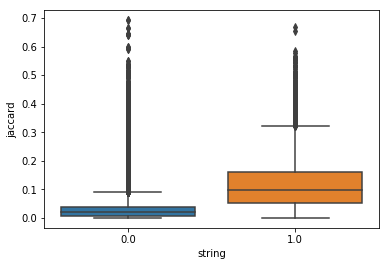

In [4]:
# Reconstruction

sns.boxplot(x='string', y='jaccard', data=test_df)

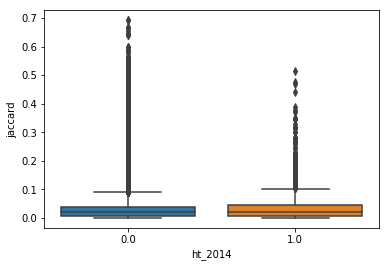

In [5]:
# Predicting systematic edges

sns.boxplot(x='ht_2014', y='jaccard', data=test_df)

In [18]:
records = (
    (feature,
     sklearn.metrics.roc_auc_score(test_df['string'], multiplier * test_df[feature]),
     sklearn.metrics.roc_auc_score(test_df['ht_2014'], multiplier * test_df[feature]))
    + scipy.stats.pearsonr(test_df['mean_degree'], test_df[feature])[:1]
    + scipy.stats.spearmanr(test_df['mean_degree'], test_df[feature])[:1]
    for feature, multiplier in {'prior_empirical': 1, 'mean_degree': 1, 'rwr': 1, 'mean_rwr': 1, 'p_rwr': -1, 
                                'jaccard': 1, 'mean_jaccard': 1, 'p_jaccard': -1,
                               }.items()
)
info_df = pd.DataFrame.from_records(records, columns=['feature', 'reconstruction_auc', 'systematic_auc', 
                                                      'pearson_degree', 'spearman_degree',])

info_df

,feature,reconstruction_auc,systematic_auc,pearson_degree,spearman_degree
0,prior_empirical,0.779547,0.489306,0.893961,0.924923
1,mean_degree,0.792245,0.488481,1.000000,1.000000
2,rwr,0.952685,0.584170,0.085718,0.586187
3,mean_rwr,0.715640,0.483546,0.583897,0.670161
4,p_rwr,0.896921,0.610555,0.087405,0.067147
5,jaccard,0.868947,0.527081,0.653109,0.676305
6,mean_jaccard,0.790945,0.484783,0.938258,0.922580
7,p_jaccard,0.840732,0.541919,-0.249554,-0.332197


## Plot ROC curves

In [113]:
colors = {
    'prior_empirical': 'prior', 'mean_degree': 'prior',
    'mean_rwr': 'RWR', 'rwr': 'RWR', 'p_rwr': 'RWR',
    'mean_jaccard': 'Jaccard', 'jaccard': 'Jaccard', 'p_jaccard': 'Jaccard',
}
info_content = {
    'prior_empirical': 'no edge info', 'mean_degree': 'no edge info',
    'mean_rwr': 'no edge info', 'rwr': 'feature', 'p_rwr': 'corrected feature',
    'mean_jaccard': 'no edge info', 'jaccard': 'feature', 'p_jaccard': 'corrected feature',
}

all_features_df = pd.DataFrame()
for feature, multiplier in {'prior_empirical': 1, 
                            'rwr': 1, 'mean_rwr': 1, 'p_rwr': -1, 
                            'jaccard': 1, 'mean_jaccard': 1, 'p_jaccard': -1,
                           }.items():
    train_df = pd.DataFrame()
    train_df['fpr'], train_df['tpr'], _ = sklearn.metrics.roc_curve(
        df.query('uniprot_a != uniprot_b')['train'], multiplier * df.query('uniprot_a != uniprot_b')[feature])
    train_df = train_df.assign(test='train')
    
    recon_df = pd.DataFrame()
    recon_df['fpr'], recon_df['tpr'], _ = sklearn.metrics.roc_curve(
        test_df['string'], multiplier * test_df[feature])
    recon_df = recon_df.assign(test='reconstruction')
    
    systematic_df = pd.DataFrame()
    systematic_df['fpr'], systematic_df['tpr'], _ = sklearn.metrics.roc_curve(
        test_df['ht_2014'], multiplier * test_df[feature])
    systematic_df = systematic_df.assign(test='systematic')
    
    feature_df = pd.concat([train_df, recon_df, systematic_df], ignore_index=True).assign(
        feature=feature, color=colors[feature], info=info_content[feature])
    all_features_df = pd.concat([all_features_df, feature_df])

all_features_df.head()

,fpr,tpr,test,feature,color,info
0,0.000000,0.000000,train,prior_empirical,prior,no edge info
1,0.000000,0.000026,train,prior_empirical,prior,no edge info
2,0.000001,0.000053,train,prior_empirical,prior,no edge info
3,0.000003,0.000053,train,prior_empirical,prior,no edge info
4,0.000004,0.000066,train,prior_empirical,prior,no edge info


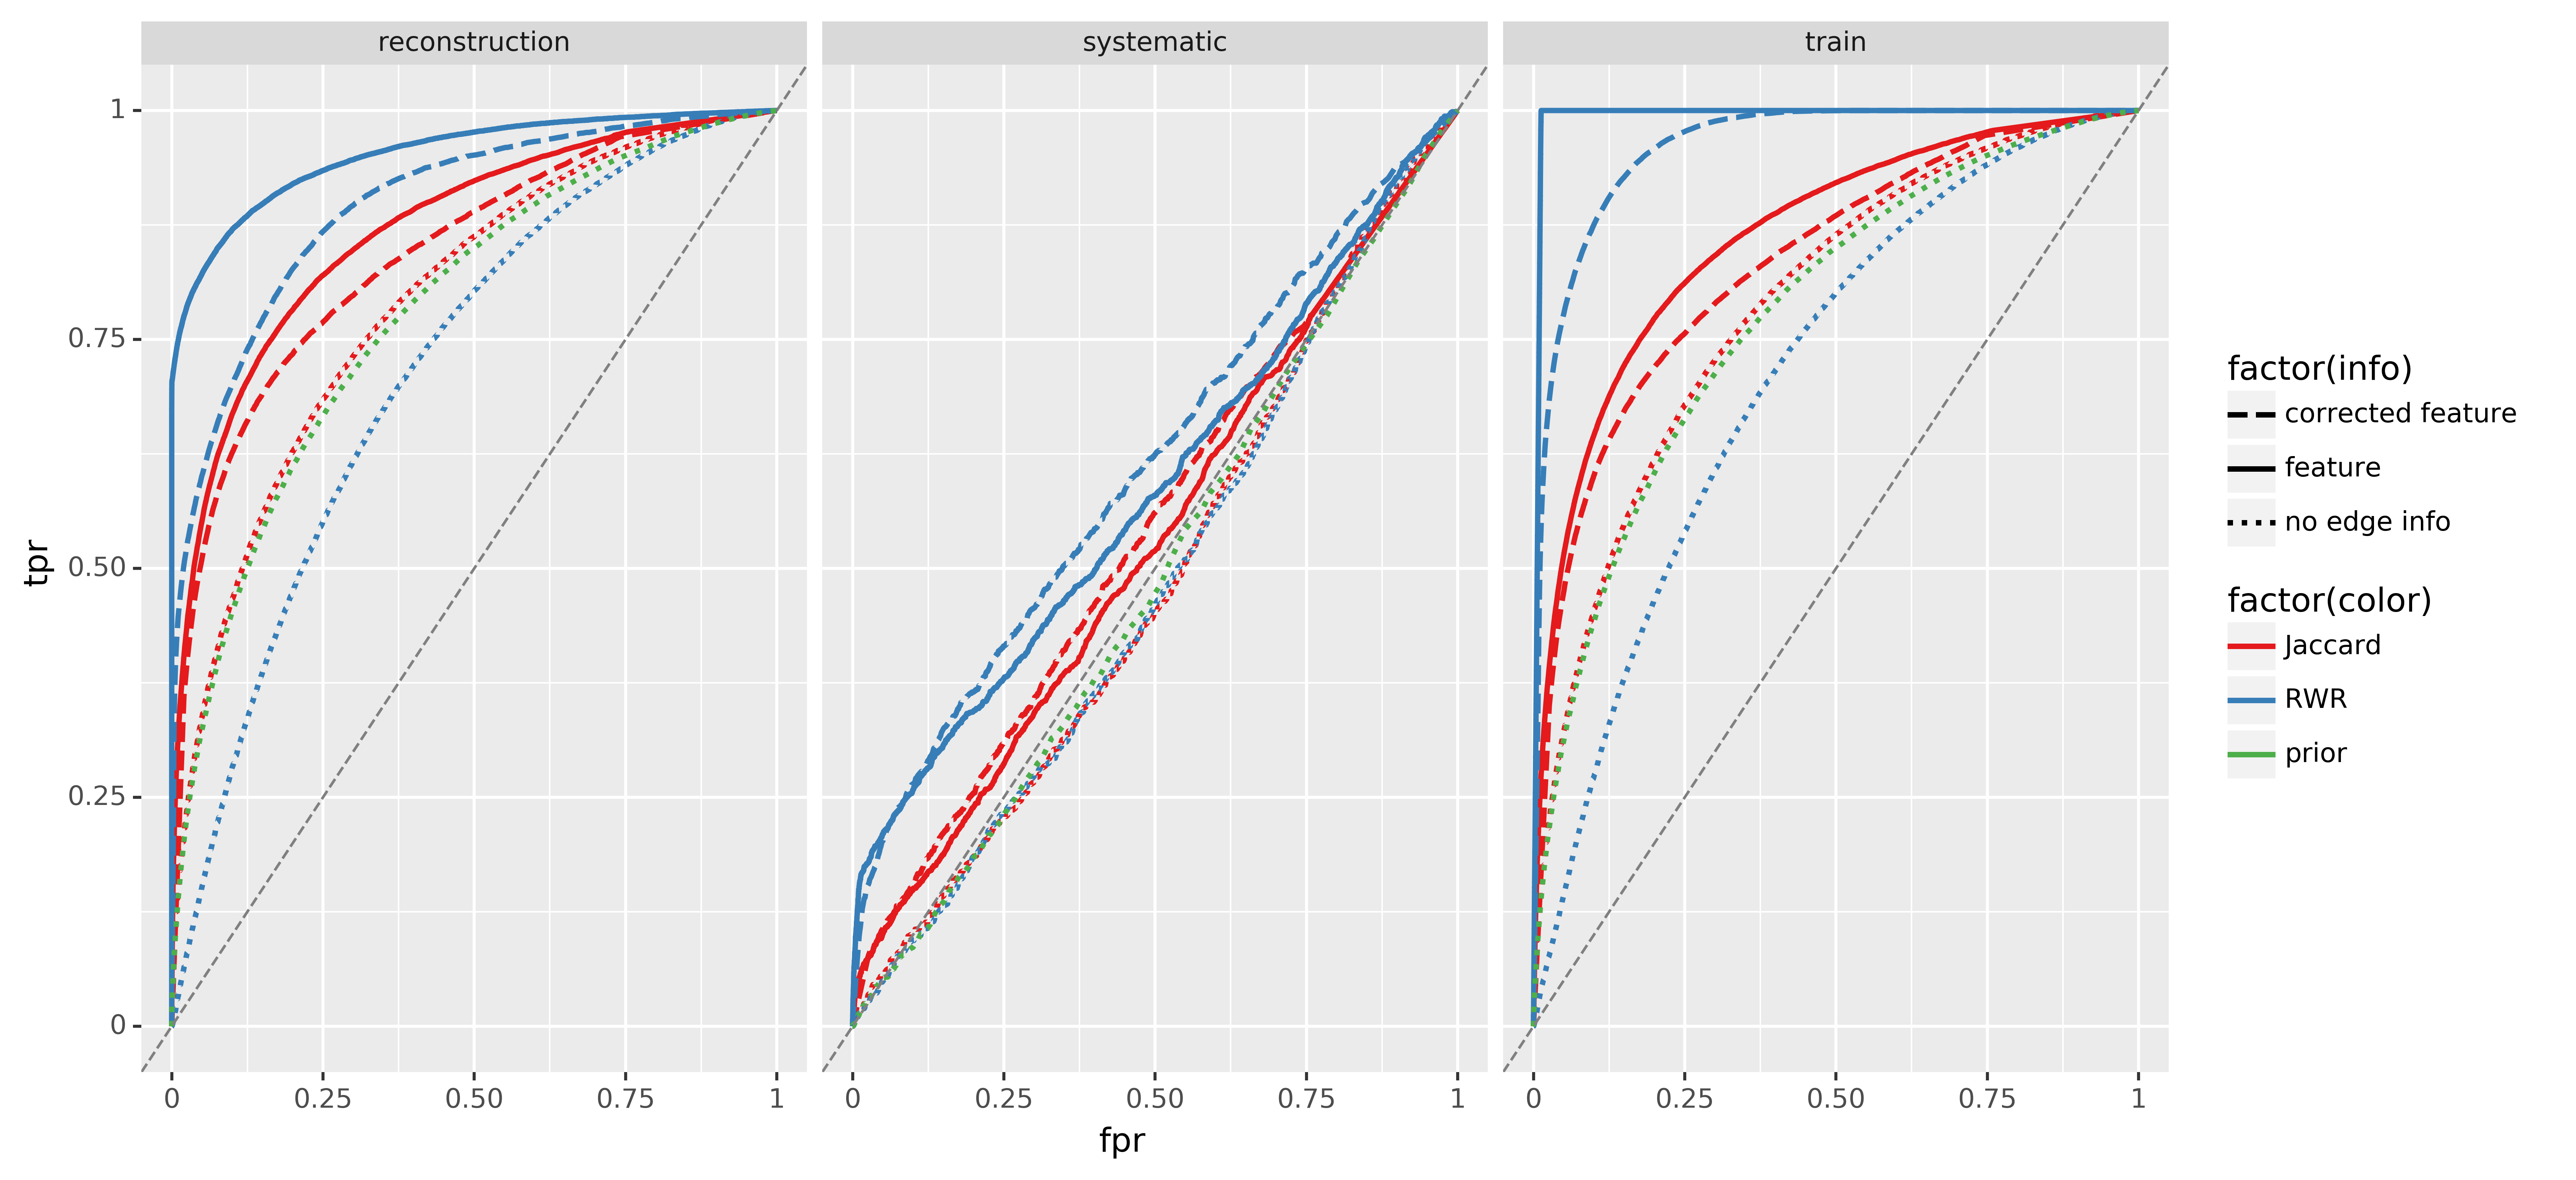

<ggplot: (8779016305335)>

In [114]:
plotnine.options.figure_size = (12, 6)
plotnine.options.dpi = 600
(
    plotnine.ggplot(all_features_df, plotnine.aes(x='fpr', y='tpr', color='factor(color)', 
                                                  linetype='factor(info)'))
    + plotnine.geom_line(size=1)
    + plotnine.facet_wrap('~test')
    + plotnine.geom_abline(slope=1, intercept=0, linetype='dashed', color='grey')
    + plotnine.scale_linetype_manual(values=['dashed', 'solid', 'dotted'])
    + plotnine.scale_color_brewer(type='qual', palette=6)
)

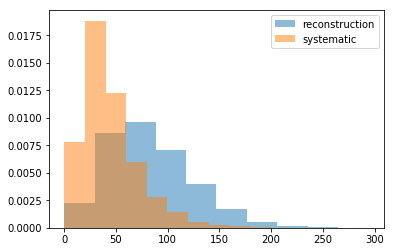

In [121]:
plt.hist(test_df.query('string == 1 and train == 0')['mean_degree'], label='reconstruction', alpha=0.5, density=True)
plt.hist(test_df.query('ht_2014 == 1 and train == 0')['mean_degree'], label='systematic', alpha=0.5, density=True)
plt.legend()